# Neural net feature classifier

Feature-based supervised clsssification of structures localized by cryo-electron tomography by Neural nets. The following steps are performed:

* Search for optimal hyperparameters and datasets by cross-validation 
* Training
* Prediction

The structures classified here are protein bridges that link plasma membrane and synaptic vesicles (tethers), bioRxiv https://doi.org/10.1101/2024.12.18.629213

Prerequisites (input data):
* Table of features for all structures
* Annotated subset of structures

Instructions:

* All cells from Initialization section have to be executed first, in order
* Cells from Logistiregression and Support vector machine can be executed in any order

Uses Pytorch

## Initialization

In [1]:
import os
import sys
import importlib
import pickle
from collections import OrderedDict

import numpy as np
import scipy as sp
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
try:
    from IPython.core.display import HTML  # depreciated
except ImportError:
    from IPython.display import display, HTML

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
#import torchmetrics
#import torchinfo

import sklearn as sk
import sklearn.metrics
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV

import pyto
from pyto.io.pandas_io import PandasIO  
from pyto.projects.presynaptic import Presynaptic

from pyto.ai.ml_supervised import MLSupervised 
import pyto.ai.feature_transform_tethers  
from pyto.ai.feature_transform_tethers import combine_features
from pyto.ai.feature_transform_tethers import transform_df, get_transformer_robust
from pyto.ai.feature_transform_tethers import get_transformer_logstd, get_transformer_logrobust
import pyto.ai.pytorch_plus as pytorch_plus
from pyto.ai.classification_nn import ClassificationNN
from pyto.ai.features_dataset_nn import FeaturesDatasetNN
from pyto.ai.full_connect import FullConnect

#%autosave 0
sys.version, torch.__version__

Info: PySeg could not be loaded. This is needed only if Pyto is used to further process PySeg generated files. In this case, calling pyto.spatial.ParticleSetsfrom_pyseg() will fail. Everything else should be fine.


('3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:50:58) [GCC 12.3.0]',
 '2.2.1')

In [2]:
# Settings

# force showing all rows in a table (default 60 rows)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

# set hostname
hostname = os.uname()[1]
print("Host name: ", hostname)

Host name:  rauna


### General parameters and setup

In [3]:
# Parameters 

# Need to be consistent with output of munc13-snap25

# Directory where input data for ML is saved (absolute or 
# relative to this dir). These incude:
#   - munc13 snap25 presynaptic project data
#   - additional munc13 snap25 presynaptic analysis
#   - manual annotations
input_dir = 'input_data/tethers'

# The following are file names without extension

# Tether indexed and scalar data (original data, additional 
# features and annotations)
data_base = 'm13-snap25_data'
metadata_base = 'm13-snap25_metadata'

# Directories where trained nets and predictions are saved
output_dir_net = 'output_data/nn_model'
output_dir_predict = 'output_data/nn_predict'


# device (chose one)
device = None
device = 'cpu'
#device = 'cuda'

# Paths initialization

# make paths from the above (absolute or relative to this directory)
data_path = os.path.join(input_dir, data_base)
metadata_path = os.path.join(input_dir, metadata_base)

# Initialize object used to handle additional munc13-snap25 features
df_io = PandasIO(calling_dir=os.getcwd())
feat = Presynaptic(df_io=df_io)

# try to get cuda device
if device is None:
    device = torch.device(
        "cuda" if torch.cuda.is_available() else "cpu")
print(f"Host: {hostname}, Device: {device}, PyTorch version {torch.__version__}")

Host: rauna, Device: cpu, PyTorch version 2.2.1


In [4]:
# plot labels
labels = {
    "<class 'torch.optim.sgd.SGD'>": 'SGD', 
    "<class 'torch.optim.adam.Adam'>": 'Adam', 
    "[17, 30, 30, 30, 30, 3]": "4x30",
    "[17, 30, 30, 30, 3]": "3x30",
    "[17, 32, 32, 32, 32, 32, 32, 32, 32, 3]": "8x32",
    "[17, 18, 18, 18, 3]": "3x18",
    "[17, 18, 18, 18, 18, 3]": "4x18",
    "[17, 18, 18, 18, 18, 18, 3]": "5x18",
    "[17, 18, 18, 18, 18, 18, 18, 18, 18, 3]": "8x18",
    "[17, 12, 12, 12, 3]": "3x12",
    "[17, 10, 10, 10, 3]": "3x10",
    "[17, 10, 10, 10, 10, 3]": "4x10",
    "[17, 18, 8, 6, 3]": "18-8-6",
    "n_features": "net",
    'dropout': 'drop', 
    'Softmax(dim=1)': 'Softmax', 'Sigmoid()': 'Sigmoid'}

### Get data

In [5]:
# useful groups of columns

# common columns
common_cols = ['group', 'identifiers', 'ids']

# basic features (used for the manuscript)
features_basic = [
    'thresh', 'thresh_rank', 'density_mean', 'density_std',
    'length_nm', 'length_min_nm', 'length_median_nm', 'length_max_nm',
    'boundary_distance_nm', 'distance_nm', 
    'surface_nm', 'volume_nm', 'euler', 'n_loops']

# standard features (original and derived wo highly correlated) v2
features_std_v2 = [
    'length_nm', 'length_max_nm',
    'boundary_distance_nm', 'distance_nm', 'length_curve', 'length_max_min', 
    'length_curve_ratio', 'length_max_min_ratio', 
    'length_bound_ratio',
    'thresh_rank', 'volume_nm', 'v-s', 'svr',
    'len_v_ratio', 'n_loops', 'loops_v_ratio'] 

In [6]:
# Read data 

input_data = df_io.read_table(
    base=data_path, 
    out_desc='Full analysis with Munc13 and SNARE annotations')
metadata = df_io.read_table(
    base=metadata_path, 
    out_desc='Full analysis with Munc13 and SNARE annotations metadata')

# training data, add combinations of features
munc13_data = MLSupervised().get_labeled(df=input_data, column='munc13').copy()
munc13_data, comb_features = combine_features(munc13_data)

# prediction data
input_data_feat, comb_features = combine_features(input_data)
munc13_prediction_data = input_data_feat.loc[
    np.setdiff1d(input_data_feat.index, munc13_data.index), :]


Read Full analysis with Munc13 and SNARE annotations pickled json string from input_data/tethers/m13-snap25_data_json.pkl
Read Full analysis with Munc13 and SNARE annotations metadata pickled json string from input_data/tethers/m13-snap25_metadata_json.pkl


## CV parameter search

Cells in this section have to be executed in order

In [7]:
# Data specified as feature and target ndarrays

features = features_std_v2
target = 'munc13_code'
data_df = munc13_data

batch_size = 30
random_state = 18

X_df = data_df[features]
y_df = data_df[target].astype(int)

X_df_train, X_df_test, y_df_train, y_df_test = sk.model_selection.train_test_split(
        X_df, y_df, random_state=random_state)
X_train = X_df_train.to_numpy()
X_test = X_df_test.to_numpy()
y_train = y_df_train.to_numpy()
y_test = y_df_test.to_numpy()

train_data = FeaturesDatasetNN(X=X_train, y=y_train, device=device)
#test_data = FeaturesDatasetNN(X=X_test, y=y_test, device=device)
X_test_scaled = sklearn.preprocessing.StandardScaler().fit_transform(X_test)
test_data_scaled = FeaturesDatasetNN(X=X_test_scaled, y=y_test, device=device)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
#train_dataloader_one = DataLoader(train_data, batch_size=len(train_data), shuffle=False)
test_dataloader_one = DataLoader(
    test_data_scaled, batch_size=len(test_data_scaled), shuffle=False)

In [9]:
# hyperparam search

lr = 0.01
n_epochs = 400
class_weight = None
loss_fn = nn.CrossEntropyLoss
f_beta = 1
#loss_fn = pytorch_plus.FbetaLoss(beta=f_beta)
optimizer = torch.optim.Adam

n_features_in = len(features)
n_features_out = 3
n_features=[n_features_in, 64, 64, n_features_out]
activation = 'relu'
batch_norm = True
dropout = 0.25
init_weight = nn.init.kaiming_normal_
last_layer = None
#last_layer = nn.Softmax(dim=1)
#last_layer = nn.Sigmoid()
last_l1 = False
#last_l1 = True

n_batches_print = 0
log_file = f'param_search_6_nepochs-{n_epochs}/6-2/ps_6-2_0_test.log'
save_path = None

param_grid = {
    'clf__lr': [1e-2, 3e-3, 1e-3], 'clf__optimizer': [torch.optim.Adam], 
    'clf__batch_norm': [True], 'clf__activation': ['relu', 'elu', 'leaky_relu'], 
    'clf__dropout': [0, 0.2, 0.3], 'clf__init': [nn.init.kaiming_normal_],
    'clf__n_features': [
        [n_features_in, 18, 18, 18, 18, 3], [n_features_in, 18, 18, 18, 3],
        [n_features_in, 12, 12, 12, 3]],
    #'last_layer': [nn.Softmax(dim=1), nn.Sigmoid()], 'last_l1': [False, True],
    #'clf__batch_size': [20, 30, 40, 60]
}

basic = ClassificationNN(
    n_epochs=n_epochs, batch_size=batch_size, device=device, 
    loss_fn=loss_fn, class_weight=class_weight, lr=lr, optimizer=optimizer, 
    f1_average='macro', f_beta=f_beta,
    train_dataloader=train_dataloader, test_dataloader=test_dataloader_one,
    n_features=n_features, activation=activation, 
    batch_norm=batch_norm, dropout=dropout, init=init_weight,
    last_layer=last_layer, last_l1=last_l1,     
    n_batches_print=n_batches_print, log_file=log_file, save_path=save_path,
    cm_epochs_print=n_epochs, report_epochs_print=n_epochs)

pipe = sk.pipeline.Pipeline([
    ("scaler", sklearn.preprocessing.StandardScaler()), ("clf", basic)])
param_search = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_macro')

%time param_search.fit(X_train, y_train)

CPU times: user 1h 49min 6s, sys: 45min 35s, total: 2h 34min 42s
Wall time: 1h 33min 36s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        <pyto.ai.classification_nn.ClassificationNN object at 0x7381cf6232c0>)]),
             param_grid={'clf__activation': ['relu', 'elu', 'leaky_relu'],
                         'clf__batch_norm': [True],
                         'clf__dropout': [0, 0.2, 0.3],
                         'clf__init': [<function kaiming_normal_ at 0x7381d4570ae0>],
                         'clf__lr': [0.01, 0.003, 0.001],
                         'clf__n_features': [[16, 18, 18, 18, 18, 3],
                                             [16, 18, 18, 18, 3],
                                             [16, 12, 12, 12, 3]],
                         'clf__optimizer': [<class 'torch.optim.adam.Adam'>]},
             scoring='f1_macro')

In [10]:
# save the resuts table
df_io = PandasIO(calling_dir=os.getcwd())
df_io.write_table(
    table=pd.DataFrame(param_search.cv_results_), 
    base=os.path.splitext(log_file)[0])

Pickled  to param_search_6_nepochs-400/6-2/ps_6-2_0_test.pkl
Pickled json converted  to param_search_6_nepochs-400/6-2/ps_6-2_0_test_json.pkl


{'n_features': [16, 18, 18, 18, 3],
 'activation': 'relu',
 'batch_norm': True,
 'dropout': 0.2,
 'init': <function torch.nn.init.kaiming_normal_(tensor: torch.Tensor, a: float = 0, mode: str = 'fan_in', nonlinearity: str = 'leaky_relu', generator: Optional[torch._C.Generator] = None)>,
 'last_layer': None,
 'last_l1': False,
 'loss_fn': torch.nn.modules.loss.CrossEntropyLoss,
 'class_weight': None,
 'train_dataloader': <torch.utils.data.dataloader.DataLoader at 0x7381ce8b6ff0>,
 'test_dataloader': <torch.utils.data.dataloader.DataLoader at 0x7381ce96d340>,
 'optimizer': torch.optim.adam.Adam,
 'lr': 0.003,
 'n_epochs': 400,
 'batch_size': 30,
 'device': 'cpu',
 'f1_average': 'macro',
 'f_beta': 1,
 'log_file': 'param_search_6_nepochs-400/6-2/ps_6-2_0_test.log',
 'n_batches_print': 0,
 'cm_epochs_print': 400,
 'report_epochs_print': 400,
 'save_path': None,
 'save_epochs': []}

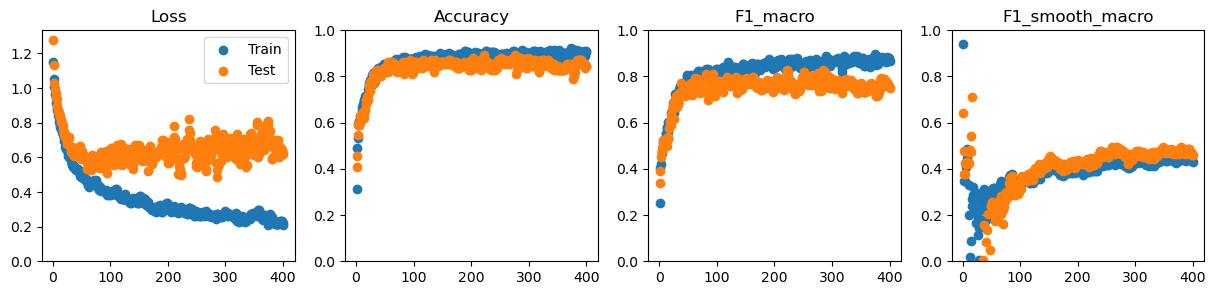

In [11]:
# best estimator performance
param_search.best_estimator_['clf'].plot()
param_search.best_estimator_['clf'].get_params()

In [12]:
# best estimator params
param_search_cols = [
    'rank_test_score', 
    'param_clf__lr', 'param_clf__n_features', #'param_last_layer', 'param_last_l1', 'param_init',
    'param_clf__activation', 'param_clf__dropout',
    'mean_test_score', 'std_test_score', 'mean_fit_time']
search_tab = pd.DataFrame(param_search.cv_results_)
#search_tab['param_init'] = search_tab['param_init'].map(lambda x: str(x.__name__))
search_tab[param_search_cols]

,rank_test_score,param_clf__lr,param_clf__n_features,param_clf__activation,param_clf__dropout,mean_test_score,std_test_score,mean_fit_time
0,45,0.01,"[16, 18, 18, 18, 18, 3]",relu,0,0.658992,0.092092,16.007007
1,68,0.01,"[16, 18, 18, 18, 3]",relu,0,0.637510,0.030161,13.885695
2,62,0.01,"[16, 12, 12, 12, 3]",relu,0,0.644453,0.069670,13.739980
3,59,0.003,"[16, 18, 18, 18, 18, 3]",relu,0,0.645638,0.074585,15.967137
4,66,0.003,"[16, 18, 18, 18, 3]",relu,0,0.638863,0.054155,13.920006
5,16,0.003,"[16, 12, 12, 12, 3]",relu,0,0.689193,0.047851,13.807673
6,57,0.001,"[16, 18, 18, 18, 18, 3]",relu,0,0.648110,0.057486,15.768706
7,75,0.001,"[16, 18, 18, 18, 3]",relu,0,0.629001,0.057231,13.736109
8,79,0.001,"[16, 12, 12, 12, 3]",relu,0,0.621321,0.060470,13.633329
9,30,0.01,"[16, 18, 18, 18, 18, 3]",relu,0.2,0.671870,0.062298,16.528412


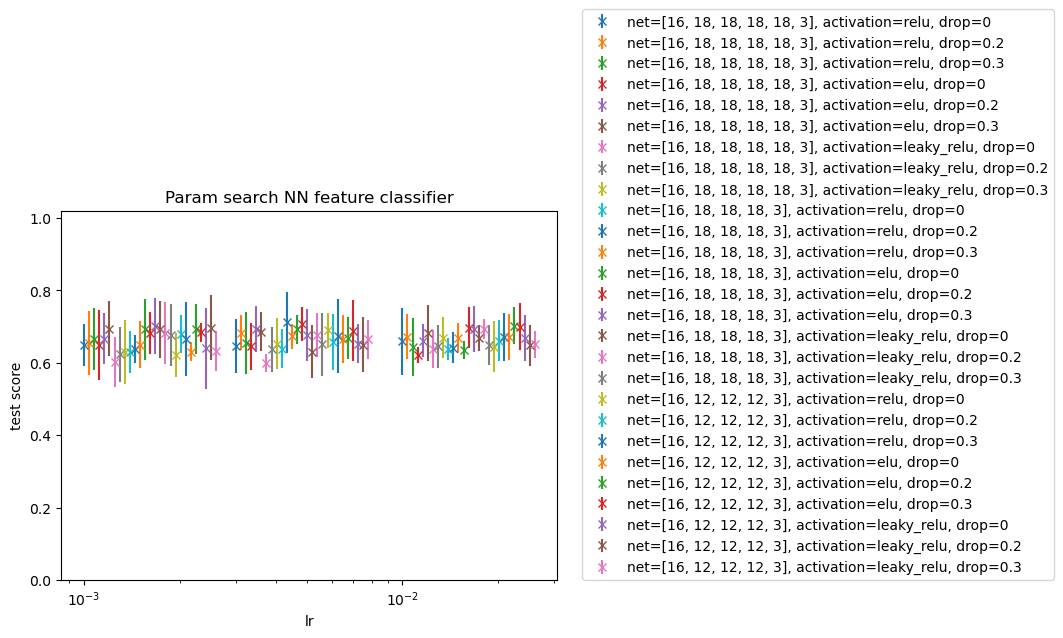

In [14]:
# test scores for all CVs
ax = MLSupervised.plot_param_search_cv(
    df=search_tab, name=['lr', 'n_features', 'activation', 'dropout'], 
    increment=0.032, x_log=True, 
    labels=labels, linestyle='', title='NN feature classifier')
ax.legend(loc=[1.05, 0])
ax.set_ylabel('test score');

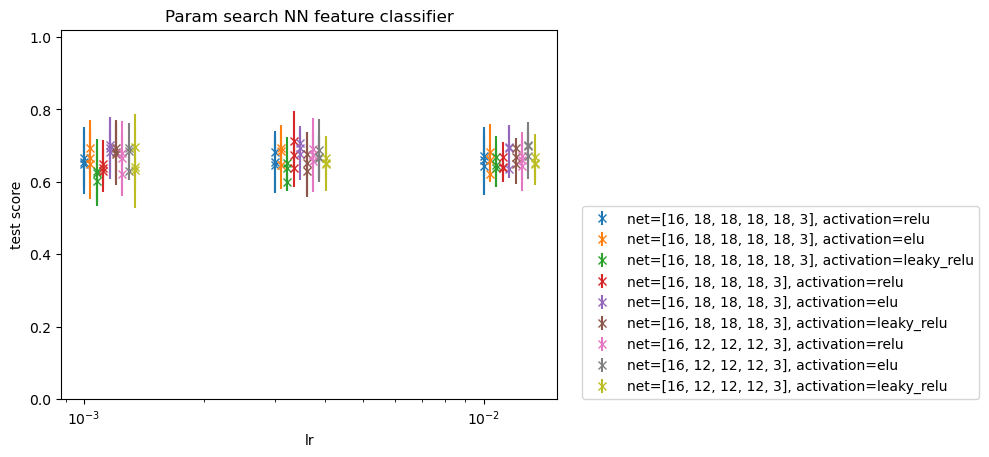

In [15]:
# test scores for all CVs
ax = MLSupervised.plot_param_search_cv(
    df=search_tab, name=['lr', 'n_features', 'activation'],#, 'dropout'], 
    increment=0.032, x_log=True, 
    labels=labels, linestyle='', title='NN feature classifier')
ax.legend(loc=[1.05, 0])
ax.set_ylabel('test score');

## Training one NN

Cells in this section have to be executed in order

In [11]:
# Data specified as feature and target ndarrays

features = features_std_v2
target = 'munc13_code'
#target = ['mun_no', 'mun', 'munc13']
data_df = munc13_data
#device = 'cuda'

batch_size = 30
random_state = 18

X_df = data_df[features]
y_df = data_df[target].astype(int)

X_df_train, X_df_test, y_df_train, y_df_test = sk.model_selection.train_test_split(
        X_df, y_df, random_state=random_state)
X_train = X_df_train.to_numpy()
X_test = X_df_test.to_numpy()
y_train = y_df_train.to_numpy()
y_test = y_df_test.to_numpy()

X_train_scaled = sklearn.preprocessing.StandardScaler().fit_transform(X_train)
X_test_scaled = sklearn.preprocessing.StandardScaler().fit_transform(X_test)

train_data = FeaturesDatasetNN(X=X_train_scaled, y=y_train, device=device)
test_data = FeaturesDatasetNN(X=X_test_scaled, y=y_test, device=device)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader_one = DataLoader(
    test_data, batch_size=len(test_data), shuffle=False)

Host: rauna, Device: cpu
Parameters: {'n_features': [16, 18, 18, 18, 18, 3], 'activation': 'relu', 'batch_norm': True, 'dropout': 0.3, 'init': 'kaiming_normal', 'last_layer': Softmax(dim=1), 'last_l1': True, 'loss_fn': <pyto.ai.pytorch_plus.F1Loss object at 0x79c422c09be0>, 'class_weight': None, 'train_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x79c423b4fd10>, 'test_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x79c4250b5730>, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'n_epochs': 1000, 'batch_size': 30, 'device': 'cpu', 'f1_average': 'macro', 'f_beta': 1, 'log_file': None, 'n_batches_print': 0, 'cm_epochs_print': 1000, 'report_epochs_print': 1000, 'save_path': 'output_data/nn_model/6.4b/clf_ps-6-4b.pkl', 'save_epochs': [], 'init_epoch': 1}

Epoch 1000
Training data Accuracy: 0.908, Avg loss: 0.181649
Test data Accuracy: 0.836, Avg loss: 0.276778


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,22,6,2,9,6,1
1,2,37,9,0,9,9
2,0,11,238,0,2,74


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,22.34,5.65,2.01,9.01,6.13,0.86
1,1.71,37.72,8.57,0.00,9.22,8.78
2,0.00,10.95,238.05,0.00,1.97,74.03



Test classification report:
              precision    recall  f1-score   support

           0       0.56      1.00      0.72         9
           1       0.50      0.53      0.51        17
           2       0.97      0.88      0.93        84

    accuracy                           0.84       110
   macro avg       0.68      0.80      0.72       110
weighted avg       0.87      0.84      0.84       110

   smooth macro                        0.72
smooth weighted                        0.83


Classifier pickled as output_data/nn_model/6.4b/clf_ps-6-4b_epoch-1000.pkl
CPU times: user 56.2 s, sys: 22.4 s, total: 1min 18s
Wall time: 45.8 s


(<Figure size 1500x300 with 4 Axes>,
 array([<Axes: title={'center': 'Loss'}>,
        <Axes: title={'center': 'Accuracy'}>,
        <Axes: title={'center': 'F1_macro'}>,
        <Axes: title={'center': 'F1_smooth_macro'}>], dtype=object))

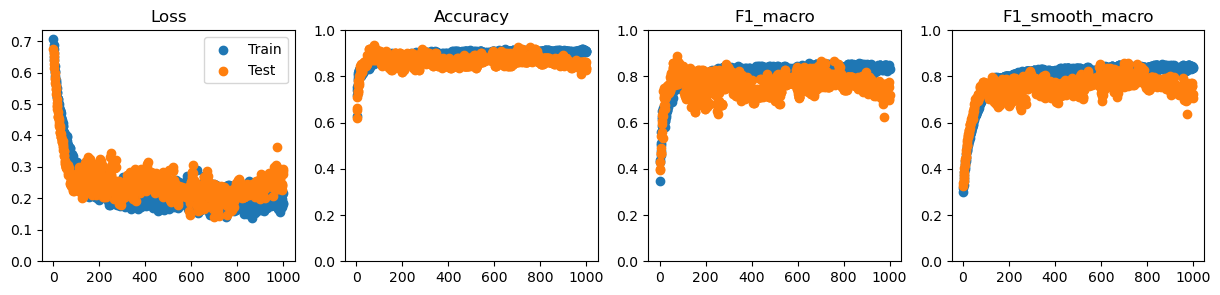

In [12]:
# Training, first 1000 epochs 

lr = 0.001
n_epochs = 1000
class_weight = None
#loss_fn = nn.CrossEntropyLoss
loss_fn = pytorch_plus.F1Loss()
optimizer = torch.optim.Adam

n_features_in = len(features)
n_features_out = 3
n_features=[n_features_in, 18, 18, 18, 18, n_features_out]
activation = 'relu'
batch_norm = True
dropout = 0.3
init_weights = 'kaiming_normal'
#last_layer = None
last_layer = nn.Softmax(dim=1)
last_l1 = True

n_batches_print = 0
log_file = None
save_path = f'{output_dir_net}/6.4b/clf_ps-6-4b.pkl'

basic = ClassificationNN(
    n_epochs=n_epochs, batch_size=batch_size, device=device, 
    lr=lr, optimizer=optimizer, 
    loss_fn=loss_fn, f1_average='macro', class_weight=class_weight, 
    n_features=n_features, activation=activation, 
    batch_norm=batch_norm, dropout=dropout, init=init_weights,
    last_layer=last_layer, last_l1=last_l1,   
    train_dataloader=train_dataloader, test_dataloader=test_dataloader_one,
    n_batches_print=n_batches_print, log_file=log_file, save_path=save_path,
    cm_epochs_print=n_epochs, report_epochs_print=n_epochs)
%time basic.run(train_dataloader, test_dataloader_one)
basic.plot()

Classifier loaded from output_data/nn_model/6.4b/clf_ps-6-4b_epoch-1000.pkl
Host: rauna, Device: cpu
Parameters: {'n_features': [16, 18, 18, 18, 18, 3], 'activation': 'relu', 'batch_norm': True, 'dropout': 0.3, 'init': 'kaiming_normal', 'last_layer': Softmax(dim=1), 'last_l1': True, 'loss_fn': <pyto.ai.pytorch_plus.F1Loss object at 0x79c418524590>, 'class_weight': None, 'train_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x79c4186ec230>, 'test_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x79c41850dd60>, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.0003, 'n_epochs': 1000, 'batch_size': 30, 'device': 'cpu', 'f1_average': 'macro', 'f_beta': 1, 'log_file': None, 'n_batches_print': 0, 'cm_epochs_print': 1000, 'report_epochs_print': 1000, 'save_path': 'output_data/nn_model/6.4b/clf_ps-6-4b.pkl', 'save_epochs': [], 'init_epoch': 1001}

Epoch 2000
Training data Accuracy: 0.911, Avg loss: 0.172122
Test data Accuracy: 0.855, Avg loss: 0.256727


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,23,5,2,9,7,0
1,2,38,8,0,10,8
2,0,12,237,0,1,75


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,23.36,4.64,2.01,9.06,6.92,0.02
1,1.52,38.60,7.88,0.00,10.14,7.86
2,0.00,11.99,237.01,0.00,1.00,75.00



Test classification report:
              precision    recall  f1-score   support

           0       0.56      1.00      0.72         9
           1       0.56      0.56      0.56        18
           2       0.99      0.90      0.94        83

    accuracy                           0.85       110
   macro avg       0.70      0.82      0.74       110
weighted avg       0.88      0.85      0.86       110

   smooth macro                        0.74
smooth weighted                        0.85


Classifier pickled as output_data/nn_model/6.4b/clf_ps-6-4b_epoch-2000.pkl


(<Figure size 1500x300 with 4 Axes>,
 array([<Axes: title={'center': 'Loss'}>,
        <Axes: title={'center': 'Accuracy'}>,
        <Axes: title={'center': 'F1_macro'}>,
        <Axes: title={'center': 'F1_smooth_macro'}>], dtype=object))

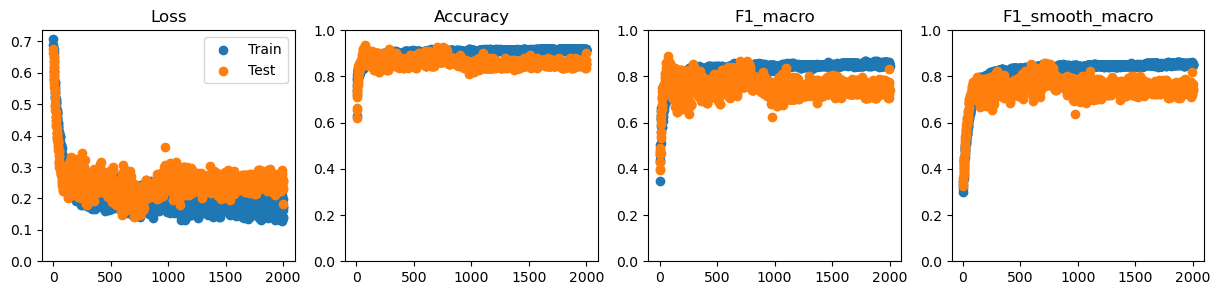

In [13]:
# Continue training with lower lr
basic = ClassificationNN.load(f'{output_dir_net}/6.4b/clf_ps-6-4b_epoch-1000.pkl')
basic.set_params(lr=0.0003, n_epochs=1000, save_epochs=[])
basic.run(train_dataloader, test_dataloader_one)
basic.plot()

Classifier loaded from output_data/nn_model/6.4b/clf_ps-6-4b_epoch-2000.pkl
Host: rauna, Device: cpu
Parameters: {'n_features': [16, 18, 18, 18, 18, 3], 'activation': 'relu', 'batch_norm': True, 'dropout': 0.3, 'init': 'kaiming_normal', 'last_layer': Softmax(dim=1), 'last_l1': True, 'loss_fn': <pyto.ai.pytorch_plus.F1Loss object at 0x79c41847f7a0>, 'class_weight': None, 'train_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x79c4184a0e60>, 'test_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x79c4186d8110>, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.0001, 'n_epochs': 2000, 'batch_size': 30, 'device': 'cpu', 'f1_average': 'macro', 'f_beta': 1, 'log_file': None, 'n_batches_print': 0, 'cm_epochs_print': 1000, 'report_epochs_print': 1000, 'save_path': 'output_data/nn_model/6.4b/clf_ps-6-4b.pkl', 'save_epochs': [], 'init_epoch': 2001}

Epoch 3000
Training data Accuracy: 0.920, Avg loss: 0.172652
Test data Accuracy: 0.855, Avg loss: 0.252859


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,24,4,2,10,6,0
1,1,39,8,0,9,9
2,0,11,238,0,1,75


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,23.94,4.05,2.00,10.18,5.80,0.02
1,1.15,39.27,7.59,0.00,8.88,9.12
2,0.00,10.96,238.04,0.00,1.00,75.00



Test classification report:
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        10
           1       0.50      0.56      0.53        16
           2       0.99      0.89      0.94        84

    accuracy                           0.85       110
   macro avg       0.70      0.82      0.75       110
weighted avg       0.88      0.85      0.86       110

   smooth macro                        0.75
smooth weighted                        0.85



Epoch 4000
Training data Accuracy: 0.920, Avg loss: 0.175227
Test data Accuracy: 0.873, Avg loss: 0.213354


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,24,4,2,10,6,0
1,1,41,6,0,11,7
2,0,13,236,0,1,75


,0_train,1_train,2_train,0_test,1_test,2_test
True,,,,,,
0,23.97,4.02,2.01,10.44,5.54,0.02
1,1.00,41.09,5.91,0.04,11.06,6.89
2,0.00,12.89,236.10,0.00,1.00,75.00



Test classification report:
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        10
           1       0.61      0.61      0.61        18
           2       0.99      0.91      0.95        82

    accuracy                           0.87       110
   macro avg       0.74      0.84      0.78       110
weighted avg       0.89      0.87      0.88       110

   smooth macro                        0.79
smooth weighted                        0.87


Classifier pickled as output_data/nn_model/6.4b/clf_ps-6-4b_epoch-4000.pkl


(<Figure size 1500x300 with 4 Axes>,
 array([<Axes: title={'center': 'Loss'}>,
        <Axes: title={'center': 'Accuracy'}>,
        <Axes: title={'center': 'F1_macro'}>,
        <Axes: title={'center': 'F1_smooth_macro'}>], dtype=object))

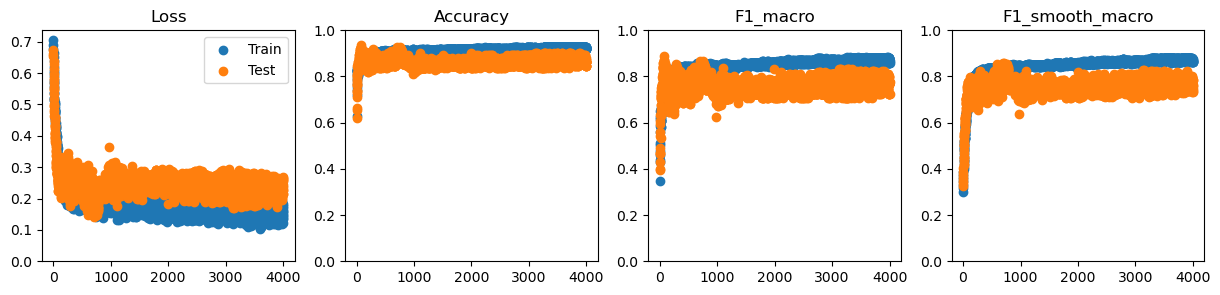

In [14]:
# Continue training with lower lr
basic = ClassificationNN.load(f'{output_dir_net}/6.4b/clf_ps-6-4b_epoch-2000.pkl')
basic.set_params(lr=0.0001, n_epochs=2000, save_epochs=[])
basic.run(train_dataloader, test_dataloader_one)
basic.plot()

## Prediction

In [15]:
# trained network pickle
nn_pkl = f'{output_dir_net}/6.4b/clf_ps-6-4b_epoch-2000.pkl'
nn_code = '6_4b_2k'

train_df = munc13_data.copy()
predict_df = munc13_prediction_data.copy()
features = features_std_v2
target = 'munc13_code'
transformer_func = sklearn.preprocessing.StandardScaler

# predict annotated data
y_train_prob, y_train_class = ClassificationNN.make_predictions(
    nn_pkl=nn_pkl, df=train_df, features=features, target=target, 
    transformer_func=transformer_func)
var_name = f'train_{nn_code}'
locals()[var_name] = y_train_class

# pedict non-annotated data
y_predict_prob, y_predict_class = ClassificationNN.make_predictions(
    nn_pkl=nn_pkl, df=predict_df, features=features, target=None, 
    transformer_func=transformer_func)

# save predictions and annotations
out_df = ClassificationNN.save_predictions(
    predict_df=predict_df, y_predict_class=y_predict_class, train_df=train_df, 
    target=target, output_dir=output_dir_predict, nn_code=nn_code)

# predictions
print("\nPredictions:")
df_loc = out_df.groupby('munc13_code')['ids'].count()
df_loc.loc['Total'] = df_loc.sum(axis=0)
print(df_loc)

Classifier loaded from output_data/nn_model/6.4b/clf_ps-6-4b_epoch-2000.pkl


,0,1,2
True,,,
0,34,10,2
1,1,52,13
2,0,14,311


,0,1,2
True,,,
0,34.11,9.87,2.02
1,1.28,51.02,13.70
2,0.00,13.79,311.21



Train classification report:
              precision    recall  f1-score   support

           0       0.74      0.97      0.84        35
           1       0.79      0.68      0.73        76
           2       0.96      0.95      0.96       326

    accuracy                           0.91       437
   macro avg       0.83      0.87      0.84       437
weighted avg       0.91      0.91      0.91       437

   smooth macro                        0.84
smooth weighted                        0.91


Classifier loaded from output_data/nn_model/6.4b/clf_ps-6-4b_epoch-2000.pkl
Pickled json converted predictions and annotations to output_data/nn_predict/6_4b_2k_json.pkl

Predictions:
munc13_code
0.0       201
1.0       373
2.0      1796
Total    2370
Name: ids, dtype: int64
